# Internet Data Analysis 

Data source: The CAIDA UCSD ITDK - 26 Sept 2024 - Present, https://catalog.caida.org/dataset/ark_itdk

*Publication notification submitted to CAIDA on 26 Sept 2024 via [this form](https://www.caida.org/catalog/datasets/publications/report-publication/) as [instructed](https://www.caida.org/about/legal/aua/public_aua/)*

I had this (in hindsight, very weak) idea that I could
 - smash out an iPhone app that traces routes to a number of Internet service providers, content delivery networks and large organizations,
 - convince a number of people to download the app (ideally traveling with it running in the background), 
 - to assemble a semi-interesting albeit sparse dataset, 
 - that once cleaned and analyzed, would help me understand how data is moved on the modern Internet

Fortunately, actual professionals have been doing this for decades and have figured out how to overcome the myriad problems associated with inferring network relationships and attribution through probing. 

Internet Routing Datasets from [CAIDA](https://www.caida.org/). 

> Founded in 1997, the Center for Applied Internet Data Analysis (CAIDA) conducts network research and builds research infrastructure to support large-scale data collection, curation, and data distribution to the scientific research community. CAIDA is based at the San Diego Supercomputer Center, located on the UC San Diego campus in La Jolla, CA.

CAIDA hosts [a range of interesting datasets](https://www.caida.org/catalog/datasets/overview/) related to their work analyzing Internet architecture and routing. 

I'll explore the illustrious Internet Topology Data Kit (ITDK) in this notebook. All schema information is sourced from a helper script (more below) and from the [ITDK documentation for the associated release](https://www.caida.org/catalog/datasets/internet-topology-data-kit/release-2023-03/). This data resulted from studying Internet routes at the *router* level. We need to understand the following things about the dataset: 
 - Interface: A physical or virtual connection used by a connected device to move traffic
 - Nodes: These are routing devices on the internet which have one or more *interfaces*. Note the collocation of these interfaces is *inferred*
 - Links: These are the **IP** connections which are inferred to be shared by two interfaces (and hence nodes), note depending on how layer 2 switching is done, these can be shared by different interfaces or nodes
 - Location: The inferred location of the *node* based on the publically available MaxMind database (also a cool dataset, albeit one behind an API) 

Steps: 
1. [Register and gain access to](https://catalog.caida.org/dataset/ark_itdk) either the restricted or the public dataset. 
2. Once through the registration wall, find the year/mont ITDK you'd like to analyze. The ITDK datasets are located in the `ark/ipv4/itdk` path. E.g. https://publicdata.caida.org/datasets/topology/ark/ipv4/itdk/2023-03/
3. Read [this](https://catalog.caida.org/recipe/parse_the_itdk) absolutely epic quickstart and sample code for parsing the dataset.
4.

In [1]:
!ls ../2023-03

README.txt                          midar-iff.links.bz2
itdk-run-20220224-dns-names.txt.bz2 midar-iff.nodes
itdk-run-20230308-dns-names.txt     midar-iff.nodes.as
itdk-run-20230308.addrs             midar-iff.nodes.as.bz2
itdk-run-20230315-dns-names.txt.bz2 midar-iff.nodes.bz2
itdk-run-20230315.addrs.bz2         midar-iff.nodes.geo
midar-iff.geo-re.jsonl.txt          midar-iff.nodes.geo.bz2
midar-iff.ifaces.bz2                speedtrap.links.bz2
midar-iff.links                     speedtrap.nodes.bz2


Run the script to validate the parsing and extract an AS entry:

```
itdk % python parse_itdk.py -a 2023-03/midar-iff.nodes.as.bz2 -l 2023-03/midar-iff.links.bz2 -n 2023-03/midar-iff.nodes.bz2 -g 2023-03/midar-iff.nodes.geo.bz2 -p 3356
Parsing Nodes AS File...
Parsing Links File...
Parsing Nodes File...
Parsing Nodes Geolocation File...
Number of Nodes found: 63316
{'asn': '3356', 'links': {'19551'}, 'interfaces': set(), 'continent': 'NA', 'country': 'US', 'region': 'PA', 'city': '39.9544', 'latitude': '-75.1657', 'longitude': 'maxmind'}
```

TO DO : 
- suggest some interesting views on the data
- use networkx package to visualize some or all of the relationships 
- use geopandas to plot the AS locations and links if possible
- attempt to animate the graph to display a dimension of the information that isn't easily portrayed in a static image... obvious one being actual temporal information which is absent from the ITDK, but is present in the ARK data
    - tutorial on animating: https://www.kaggle.com/code/kennethgranahan/plot-animate-statistical-data-with-geopandas

In [2]:
import pandas as pd

In [3]:
# ITDK location, only used if we haven't created an intermediate representation in parquet already
itdk_dir = "../2023-03"

# Subset of ITDK to expedite testing new parsing logic
itdk_mini_dir = "../2023-03-mini" 

# The transcoded and much more speedy version of the ITDK data we care about
as_file='./2023_itdk_as.parquet' 
node_file='./2023_itdk_nodes.parquet'
link_file='./2023_itdk_links.parquet' 

# Load

Rework of code supplied in https://catalog.caida.org/assets/recipe/parse_the_itdk/parse_itdk.py, note license which applies to derivative products (this whole cell). 

In [4]:
# Copyright (c) 2020 The Regents of the University of California
# All Rights Reserved

__author__ = "Donald Wolfson"
__email__ = "dwolfson@zeus.caida.org"
# This software is Copyright (C) 2020 The Regents of the University of
# California. All Rights Reserved. Permission to copy, modify, and
# distribute this software and its documentation for educational, research
# and non-profit purposes, without fee, and without a written agreement is
# hereby granted, provided that the above copyright notice, this paragraph
# and the following three paragraphs appear in all copies. Permission to
# make commercial use of this software may be obtained by contacting:
#
# Office of Innovation and Commercialization
#
# 9500 Gilman Drive, Mail Code 0910
#
# University of California
#
# La Jolla, CA 92093-0910
#
# (858) 534-5815
#
# invent@ucsd.edu
#
# This software program and documentation are copyrighted by The Regents of
# the University of California. The software program and documentation are
# supplied â€œas isâ€, without any accompanying services from The Regents. The
# Regents does not warrant that the operation of the program will be
# uninterrupted or error-free. The end-user understands that the program
# was developed for research purposes and is advised not to rely
# exclusively on the program for any reason.
#
# IN NO EVENT SHALL THE UNIVERSITY OF CALIFORNIA BE LIABLE TO ANY PARTY FOR
# DIRECT, INDIRECT, SPECIAL, INCIDENTAL, OR CONSEQUENTIAL DAMAGES,
# INCLUDING LOST PR OFITS, ARISING OUT OF THE USE OF THIS SOFTWARE AND ITS
# DOCUMENTATION, EVEN IF THE UNIVERSITY OF CALIFORNIA HAS BEEN ADVISED OF
# THE POSSIBILITY OF SUCH DAMAGE. THE UNIVERSITY OF CALIFORNIA SPECIFICALLY
# DISCLAIMS ANY WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE. THE
# SOFTWARE PROVIDED HEREUNDER IS ON AN â€œAS ISâ€ BASIS, AND THE UNIVERSITY OF
# CALIFORNIA HAS NO OBLIGATIONS TO PROVIDE MAINTENANCE, SUPPORT, UPDATES,
# ENHANCEMENTS, OR MODIFICATIONS.

################################## Imports #####################################

import argparse
import sys
import json
import bz2
import re
import pandas as pd

############################## Global Variables ################################

# Datasets
as_2_data = {}                  # Maps an asn to all of its ITDK data found.
"""
{
    "asn" : {
        "asn" : "...",
        "links" : set(),
        "interfaces" : set(),
        "continent" : "...",
        "country" : "...",
        "region" : "...",
        "city" : "...",
        "latitude" : "...",
        "longitude" : "..."
    }
}
"""
node_id_2_data = {}            # Maps a node_id to its corresponding asn and associated data.
link_2_nodes = {}             # Maps a link to its corresponding nodes

# Definitions
re_txt = re.compile(r".txt$")
re_bz2 = re.compile(r".bz2$")

# File Paths
links_file = None
nodes_file = None
nodes_geo_file = None
nodes_as_file = None

############################### Helper Methods #################################

def print_help():
    print(sys.argv[0], "-a nodes.as_file.bz2 -l links_file.bz2 -n nodes_file.bz2 -g nodes_geo_file.bz2", file=sys.stderr)
    sys.exit()


# Opens the nodes_as_file and sends each line to a helper method.
def parse_nodes_as_file():
    global re_txt
    global re_bz2
    global nodes_as_file

    # Open file as an encoded .bz2 file.
    if re_bz2.search(nodes_as_file):
        with bz2.open(nodes_as_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                curr_line = curr_line.decode()
                parse_nodes_as_body(curr_line)
                curr_line = file.readline()
    
    # Open file as a .txt file
    elif re_txt.search(nodes_as_file):
        with open(nodes_as_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                parse_nodes_as_body(curr_line)
                curr_line = file.readline()
    
    # Edge Case: Exit if a .txt or .bz2 file wasn't given
    else:
        print("All files must be either .bz2 or .txt file types.")
        print_help()


# Parses a given line of the nodes_as_file and updates as_2_data.
def parse_nodes_as_body(curr_line):
    global node_id_2_data

    # Edge Case: Skip any commented lines.
    if curr_line[0] == "#":
        return

    # Format of curr_line: "node.AS   <node_id>   <AS>   <method>"
    ignore, node_id, asn, method = curr_line.split()

    # Map the node_id to its corresponding asn and setup the objects that 
    # will be populated in follow-on parsing operations
    node_id_2_data[node_id] = {
        "asn" : asn, 
        "interfaces" : set(),
        "continent" : None,
        "country" : None,
        "region" : None,
        "city" : None,
        "latitude" : None,
        "longitude" : None
    }

# Opens the links_file and sends each line to a helper method.
def parse_links_file():
    global re_txt
    global re_bz2
    global links_file

    # Open file as an encoded .bz2 file.
    if re_bz2.search(links_file):
        with bz2.open(links_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                curr_line = curr_line.decode()
                parse_links_body(curr_line)
                curr_line = file.readline()
    
    # Open file as a .txt file
    elif re_txt.search(links_file):
        with open(links_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                parse_links_body(curr_line)
                curr_line = file.readline()
    
    # Edge Case: Exit if a .txt or .bz2 file wasn't given
    else:
        print("All files must be either .bz2 or .txt file types.")
        print_help()


# Given a string of a line from a Links File, update as_2_data.
def parse_links_body(curr_line):
    global as_2_data
    global node_id_2_data
    global link_2_nodes

    # Edge Case: Skip any commented lines.
    if curr_line[0] == "#":
        return

    # Format of curr_line: "link <link_id>: <N1>:i1 <N2>:i2 [ <N3>:[i3] ... ]"
    # E.g. "link L403:  N20197884:1.6.217.42 N76439 N76440 N76441 N76442 N76083"
    curr_line = curr_line.split()
    
    # Skip any lines that don't have any data.
    if len(curr_line) < 4:
        return
   
    # Format of curr_line: [ "link", link_id, [ N1, Interface ], N2, ... ]
    link_id = curr_line[1].strip(":") 
    curr_line[2] = curr_line[2].split(":")
    node_id = curr_line[2][0]

    # Edge Case: Skip this line if the node_id doesn't map to an asn.
    if node_id in node_id_2_data:
        asn = node_id_2_data[curr_line[2][0]]["asn"]
    else:
        return

    # Create a new link entry for this link ID
    link_2_nodes[link_id] = { 
        "nodes" : set()
    } 
    link_2_nodes[link_id]["nodes"].add(node_id) 
    
    # Create the current asn's object.
    as_2_data[asn] = {
        "asn" : asn,
        "links" : set(),
        "interfaces" : set(),
        "continent" : None,
        "country" : None,
        "region" : None,
        "city" : None,
        "latitude" : None,
        "longitude" : None
    }

    # Add the current interface if it exists.
    if len(curr_line[2]) == 2:
        interface = curr_line[2][1]
        as_2_data[asn]["interfaces"].add(interface)
    
    # Iterate over N2 to Nm and add all asns to the current link interface.
    for node in curr_line[3:]:
        # Split the node_id from the interface.
        node_data = node.split(":")
        node_id = node_data[0]
        
        if node_id in node_id_2_data:
            
            # Add the node to the link
            link_2_nodes[link_id]["nodes"].add(node_id) 
            
            # Add the link between the asn and node if the node has a mappable asn.
            curr_asn = node_id_2_data[node_id]["asn"]

            # Add the current asn to the parent asn's links set.
            as_2_data[asn]["links"].add(curr_asn)

# Opens the links_file and sends each line to a helper method.
def parse_nodes_file():
    global re_txt
    global re_bz2
    global nodes_file

    # Open file as an encoded .bz2 file.
    if re_bz2.search(nodes_file):
        with bz2.open(nodes_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                curr_line = curr_line.decode()
                parse_nodes_body(curr_line)
                curr_line = file.readline()
    
    # Open file as a .txt file
    elif re_txt.search(nodes_file):
        with open(nodes_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                parse_nodes_body(curr_line)
                curr_line = file.readline()
    
    # Edge Case: Exit if a .txt or .bz2 file wasn't given.
    else:
        print("All files must be either .bz2 or .txt file types.")
        print_help()


# Parses a given line of the nodes_file and updates as_2_data.
def parse_nodes_body(curr_line):
    global as_2_data
    global node_id_2_data
    
    # Edge Case: Skip any commented lines. 
    if curr_line[0] == "#":
        return

    # Format of curr_line: "node <node_id>: <i1> <i2> ... <in>"
    curr_line = curr_line.split()
    # Format of curr_line: [ "node", "<node_id>:", "<i1>", "<i2>", ..., "<in>" ]
    # e.g. "node N477:  14.140.178.233 14.140.179.45 14.140.179.73 14.140.179.249 ... 203.200.156.225"
    node_id = curr_line[1].replace(":","")

    # Skip line if node_id isn't mappable to an asn.
    if node_id not in node_id_2_data:
        return

    asn = node_id_2_data[node_id]["asn"]
    
    # Skip line if asn not in as_2_data.
    if asn not in as_2_data:
        return

    # Iterate over interfaces on the current line, and add them
    for interface in curr_line[2:]:
        as_2_data[asn]["interfaces"].add(interface)
        node_id_2_data[node_id]["interfaces"].add(interface)

# Opens the nodes_geo_file and sends each line to a helper method.
def parse_nodes_geo_file():
    global re_txt
    global re_bz2
    global nodes_geo_file

    # Open file as an encoded .bz2 file.
    if re_bz2.search(nodes_geo_file):
        with bz2.open(nodes_geo_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                curr_line = curr_line.decode()
                parse_nodes_geo_body(curr_line)
                curr_line = file.readline()
    
    # Open file as a .txt file
    elif re_txt.search(nodes_geo_file):
        with open(nodes_geo_file, "r") as file:
            curr_line = file.readline()
            while curr_line:
                parse_nodes_geo_body(curr_line)
                curr_line = file.readline()
    
    # Edge Case: Exit if a .txt or .bz2 file wasn't given
    else:
        print("All files must be either .bz2 or .txt file types.")
        print_help()


# Parses a given line of the nodes_geo_file and updates as_2_data.
def parse_nodes_geo_body(curr_line):
    global as_2_data
    global node_id_2_data

    # Edge Case: Skip any commented lines. 
    if curr_line == "#":
        return
    
    curr_line = curr_line.split()
    node_id = curr_line[1].replace(":","")

    # Skip line if node_id isn't mappable to an asn.
    if node_id not in node_id_2_data:
        return

    asn = node_id_2_data[node_id]["asn"]

    # Skip line if asn not in as_2_data.
    if asn not in as_2_data:
        return

    # Depending on length of curr_line update data with what is given.
    #print(curr_line)
    #print(len(curr_line))
    #raise()
    
    # len = 9: "node.geo N1272: NA      US      FL      Miami   25.793200       -80.290604                      hoiho" 
    if len(curr_line) == 9:
        as_2_data[asn]["continent"] = curr_line[2]
        node_id_2_data[node_id]["continent"] = curr_line[2]
        
        as_2_data[asn]["country"] = curr_line[3]
        node_id_2_data[node_id]["country"] = curr_line[3]
        
        as_2_data[asn]["region"] = curr_line[4]
        node_id_2_data[node_id]["region"] = curr_line[4]
        
        as_2_data[asn]["city"] = curr_line[5]
        node_id_2_data[node_id]["city"] = curr_line[5]
        
        as_2_data[asn]["latitude"] = curr_line[6]
        node_id_2_data[node_id]["latitude"] = curr_line[6]
        
        as_2_data[asn]["longitude"] = curr_line[7]
        node_id_2_data[node_id]["longitude"] = curr_line[7]
        
    # len = 8: "node.geo N1296: AS      TW              Taipei  25.047760       121.531850                      hoiho"
    elif len(curr_line) == 8:
        as_2_data[asn]["continent"] = curr_line[2]
        node_id_2_data[node_id]["continent"] = curr_line[2]
        
        as_2_data[asn]["country"] = curr_line[3]
        node_id_2_data[node_id]["country"] = curr_line[3]
               
        as_2_data[asn]["city"] = curr_line[4]
        node_id_2_data[node_id]["city"] = curr_line[4]
        
        as_2_data[asn]["latitude"] = curr_line[5]
        node_id_2_data[node_id]["latitude"] = curr_line[5]
        
        as_2_data[asn]["longitude"] = curr_line[6]
        node_id_2_data[node_id]["longitude"] = curr_line[6]
        
    elif len(curr_line) == 5:
        as_2_data[asn]["latitude"] = curr_line[2]
        node_id_2_data[node_id]["latitude"] = curr_line[2]
        
        as_2_data[asn]["longitude"] = curr_line[3]
        node_id_2_data[node_id]["longitude"] = curr_line[3]

# Print a given asn to STDOUT.
def get_as_data(asn):
    global as_2_data
    
    # Edge Case: Print error if asn not in as_2_data.
    if asn not in as_2_data:
        print("{} not in as_2_data".format(asn))
    else:
        print(as_2_data[asn])

# Load ITDK tables and return AS, Node dataframes. 
#
# Note: Modified version of original CLI tool
def load_itdk(itdk_base, compressed=True): 
    global as_2_data
    global node_id_2_data
    global ases_2_print
    global re_txt
    global re_bz2
    global links_file
    global nodes_file
    global nodes_geo_file
    global nodes_as_file
    
    nodes_file = f"{itdk_base}/midar-iff.nodes{'.bz2' if compressed else '.txt'}" 
    links_file = f"{itdk_base}/midar-iff.links{'.bz2' if compressed else '.txt'}"
    nodes_geo_file = f"{itdk_base}/midar-iff.nodes.geo{'.bz2' if compressed else '.txt'}"
    nodes_as_file = f"{itdk_base}/midar-iff.nodes.as{'.bz2' if compressed else '.txt'}"
    
    # Update node_id_2_data with data from Nodes AS file.
    print("Parsing Nodes AS File...", file=sys.stderr)
    parse_nodes_as_file()
    
    # Update as_2_data with each asn's links.
    print("Parsing Links File...", file=sys.stderr)
    parse_links_file()
    
    # Update as_2_data with each asn's interfaces.
    print("Parsing Nodes File...", file=sys.stderr)
    parse_nodes_file()
    
    # Update as_2_data with each asn's geolocation.
    print("Parsing Nodes Geolocation File...", file=sys.stderr)
    parse_nodes_geo_file()
    
    print("Number of Nodes found: {}".format(len(as_2_data)), file=sys.stderr)

    df_as = pd.DataFrame.from_dict(data=as_2_data, orient='index') 
    df_node = pd.DataFrame.from_dict(data=node_id_2_data, orient='index') 
    df_link = pd.DataFrame.from_dict(data=link_2_nodes, orient='index') 
    
    return df_as, df_node, df_link

# End Regents of the University of California copyrighted source

In [5]:
def load_asn_names(path):
    names = {}
    with open(path, 'r') as file: 
        for line in file: 
            tokens = line.split(' ', 1)
            asn = tokens[0][2:]
            name = tokens[1:][0].strip()
            names[asn] = name
    return names

🐢 The parsing operation is quite time consuming. Use an intermediate format (df serialized into a parquet file) if we've already load it and squirrelled it away, otherwise abide the lengthy parse operation, get the two table into a dataframe and write out to expedite the next go-around. 

In [6]:
testing = True

In [7]:
df_as = None
df_node = None 
df_dns = None
df_link = None 

print("Loading ITDK data...") 
if not testing: 

    try: 
        df_as = pd.read_parquet(path=as_file) 
        df_node = pd.read_parquet(path=node_file) 
        print(f"Loaded AS & node information from {as_file}, {node_file}.") 
    
    except FileNotFoundError: 
        print(f"No intermediate representation found, parsing ITDK files in {itdk_dir}.") 
    
        df_as, df_node, df_link = load_itdk(itdk_dir, compressed=True)
        df_as.to_parquet(path=as_file)
        df_node.to_parquet(path=node_file)
        df_link.to_parquet(path=link_file) 

    print("Loading DNS information...") 
    df_dns = pd.read_csv(f"{itdk_dir}/itdk-run-20230308-dns-names.txt", sep="\t", names=['timestamp', 'ip_address', 'hostname'])

else: 
    # Test set of ITDK from text files... this is not as slow!
    df_as, df_node, df_link = load_itdk(itdk_mini_dir, compressed=False)
    df_dns = pd.read_csv(f"{itdk_mini_dir}/itdk-run-20230308-dns-names.txt", sep="\t", names=['timestamp', 'ip_address', 'hostname'])

as_names = load_asn_names('../asn/asn_list.txt')
print("Done.") 

Loading ITDK data...


Parsing Nodes AS File...
Parsing Links File...
Parsing Nodes File...
Parsing Nodes Geolocation File...
Number of Nodes found: 3533


Done.


# Explore 

## Data Schema

In [8]:
df_as.head(1)

asn links                                         interfaces  \
23969  23969    {}  {203.113.37.209, 125.24.216.50, 125.24.216.238...   

      continent country region  city latitude longitude  
23969      None    None   None  None     None      None

In [9]:
df_as.count()

asn           3533
links         3533
interfaces    3533
continent     1377
country       1377
region        1280
city          1377
latitude      1377
longitude     1377
dtype: int64

In [10]:
df_node.head()

asn                                         interfaces continent  \
N1  396338                                                 {}      None   
N2   13489                                                 {}      None   
N3   31655  {138.248.209.232, 138.248.239.136, 51.52.0.110...      None   
N4   13489                                                 {}      None   
N5   31655  {138.248.180.217, 138.248.247.20, 151.2.180.34...      None   

   country region  city latitude longitude  
N1    None   None  None     None      None  
N2    None   None  None     None      None  
N3    None   None  None     None      None  
N4    None   None  None     None      None  
N5    None   None  None     None      None

In [11]:
df_node.count()

asn           500000
interfaces    500000
continent      26060
country        26060
region         23295
city           26060
latitude       26060
longitude      26060
dtype: int64

In [12]:
df_link.head()

nodes
L13                                   {N75718, N75717}
L16                                           {N75719}
L17                                   {N75718, N75720}
L18                                           {N75721}
L21  {N75760, N75774, N75759, N75779, N75761, N7576...

In [13]:
df_link.count()

nodes    45629
dtype: int64

In [14]:
df_dns.head(1)

timestamp      ip_address                              hostname
0  1678756160  73.242.190.212  c-73-242-190-212.hsd1.nm.comcast.net

In [15]:
df_dns.count()

timestamp     1246968
ip_address    1246968
hostname      1245432
dtype: int64

## Transformations

In [16]:
len(df_as['asn'].unique())

3533

In [17]:
df_as['links'].count()

np.int64(3533)

Add an explicit link count

In [18]:
def count(s): 
    return(len(s))

df_as['link_count'] = df_as['links'].apply(count)
df_as['interface_count'] = df_as['interfaces'].apply(count)
df_link['node_count'] = df_link['nodes'].apply(count) 

In [19]:
df_as[df_as['link_count']>2].head()

asn                 links  \
43260  43260  {6453, 8220, 199608}   
9105    9105    {5511, 2152, 9105}   
5607    5607   {6939, 6461, 24785}   
10848  10848    {5511, 6453, 3356}   
3491    3491    {3356, 7725, 3491}   

                                              interfaces continent country  \
43260                         {185.244.145.150, 1.1.1.5}      None    None   
9105   {212.139.88.69, 2.97.48.1, 62.24.166.5, 78.144...      None    None   
5607   {2.120.9.185, 89.200.131.8, 154.14.73.66, 2.12...      None    None   
10848                       {4.2.159.70, 67.208.150.142}        NA      US   
3491   {63.222.57.37, 63.218.7.61, 63.223.22.22, 63.2...        NA      US   

      region        city   latitude   longitude  link_count  interface_count  
43260   None        None       None        None           3                2  
9105    None        None       None        None           3              107  
5607    None        None       None        None           3              152  
10848     OH  Cincinnati  39.127110  -84.514390           3                2  
3491      IL     Chicago  41.850030  -87.650050           3              602

Shift the index off the node descriptor and update the column names

In [20]:
df_node.reset_index(inplace=True)
df_link.reset_index(inplace=True)

In [21]:
df_node.rename(columns={'index':'node'}, inplace=True)
df_link.rename(columns={'index':'link'}, inplace=True)

In [22]:
df_node.head()

node     asn                                         interfaces continent  \
0   N1  396338                                                 {}      None   
1   N2   13489                                                 {}      None   
2   N3   31655  {138.248.209.232, 138.248.239.136, 51.52.0.110...      None   
3   N4   13489                                                 {}      None   
4   N5   31655  {138.248.180.217, 138.248.247.20, 151.2.180.34...      None   

  country region  city latitude longitude  
0    None   None  None     None      None  
1    None   None  None     None      None  
2    None   None  None     None      None  
3    None   None  None     None      None  
4    None   None  None     None      None

In [23]:
df_node[df_node['continent'] == 'EU'].count()

node          8257
asn           8257
interfaces    8257
continent     8257
country       8257
region        6679
city          8257
latitude      8257
longitude     8257
dtype: int64

In [24]:
df_link.head()

link                                              nodes  node_count
0  L13                                   {N75718, N75717}           2
1  L16                                           {N75719}           1
2  L17                                   {N75718, N75720}           2
3  L18                                           {N75721}           1
4  L21  {N75760, N75774, N75759, N75779, N75761, N7576...          33

In [25]:
import matplotlib.pyplot as plt

In [26]:
def plot_groups(groups, column, width=10): 

    bar_fig, bar_ax = plt.subplots()
    bar_fig.set_figwidth(width)
    bar_fig.suptitle(f"{column} samples, by group")
    
    xlabels = [None] * len(groups)
    position = 0 
    
    for name, group in groups: 
        bar_ax.bar(height=len(group), x=name)
        
        xlabels[position] = name
        position = position + 1
    
    # Avoids complaint from MPL about setting tick labels without fixed ticks, see https://stackoverflow.com/questions/63723514/userwarning-fixedformatter-should-only-be-used-together-with-fixedlocator
    _ = bar_ax.set_xticks(xlabels)
    _ = bar_ax.set_xticklabels(xlabels, rotation=90)

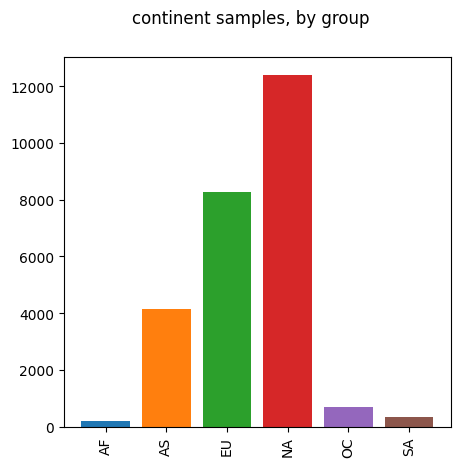

In [27]:
plot_groups(df_node.groupby(by='continent'), 'continent',5)

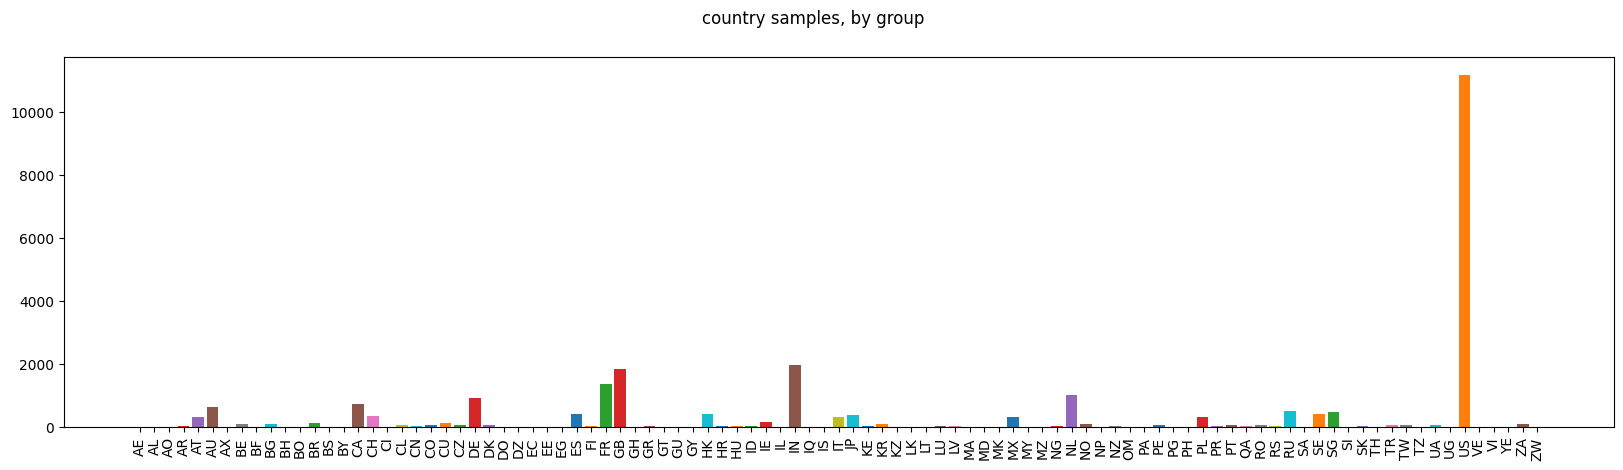

In [28]:
plot_groups(df_node.groupby(by='country'), 'country', 20)

## Visualization

### Geospatial plot for those nodes with associated data

In [29]:
import geopandas

Take a subset of the node DF to make this computable on my laptop... 

In [30]:
df_na = df_node[df_node['continent'] == 'NA']

In [31]:
df_na.count()

node          12406
asn           12406
interfaces    12406
continent     12406
country       12406
region        12232
city          12406
latitude      12406
longitude     12406
dtype: int64

In [32]:
geo_node_df = geopandas.GeoDataFrame(
    df_na,
    geometry=geopandas.points_from_xy(df_na.longitude, df_na.latitude), 
    crs="EPSG:4326"
)

In [33]:
# TO DO  - use geopandas linestrings or something to plot 

In [34]:
geo_node_df.explore()

### Heatmap to indicate density of nodes (with geo info anyway) 

In [35]:
from folium import plugins 

map - folium.Map() 

heat_data = 

SyntaxError: invalid syntax (3854531646.py, line 5)

### Link graph
Figure out how to render the links!

In [123]:
df_small = df_node[df_node['continent'] == 'AS']

In [124]:
small_nodes = df_small['node'].unique()

In [125]:
len(small_nodes) 

4157

In [126]:
import networkx as nx

In [127]:
G = nx.Graph()

In [128]:
edges = []
for index, row in df_link.iterrows(): 
    nodes = list(row['nodes']) 

    #print(nodes)
    #print(nodes[0] + "in na_nodes ?") 
    if nodes[0] in small_nodes: 
        for node in nodes: 
            
            if nodes[0] != node:
                
                #print(node + "in na_nodes ?" ) 
                if node in small_nodes: 
                    #G.add_edge(nodes[0], node, color='r', weight=5*len(nodes)/143) 
                    G.add_edge(nodes[0], node) 
                    edges.append(len(nodes))
                    #print(node + " in na_nodes") 

    # if index > 11000: 
    #     break 

In [129]:
max(edges)

73

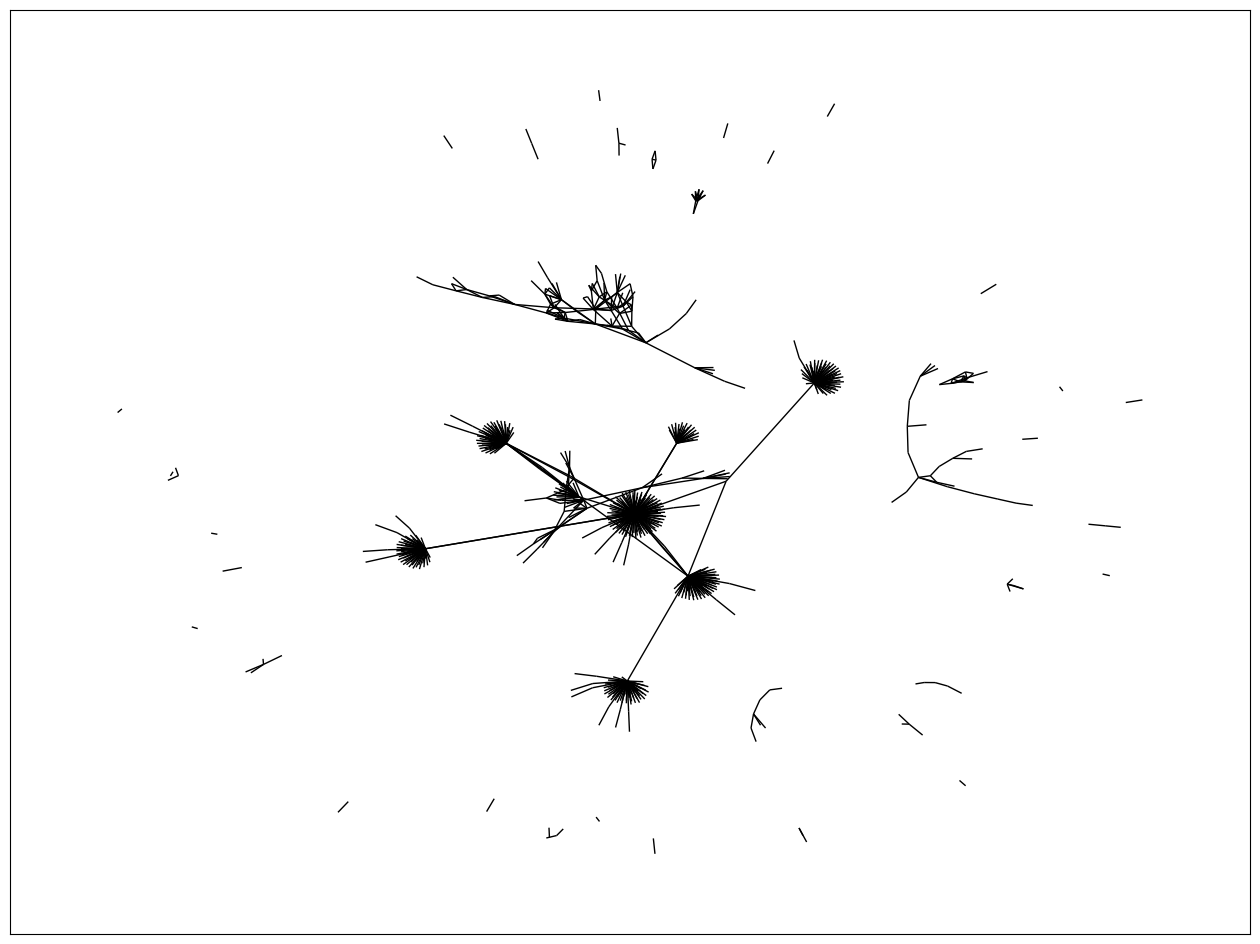

In [130]:
plt.figure(43, figsize=(16,12))
nx.draw_networkx_edges(G, pos=nx.spring_layout(G)) #, edge_color=edges) 
#nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G)) 
plt.show()

### ASN graph

In [43]:
G = nx.Graph()

In [108]:
df_as_geo = df_as[df_as['link_count']>1]

In [109]:
df_as_geo.count()

asn                232
links              232
interfaces         232
continent           72
country             72
region              66
city                72
latitude            72
longitude           72
link_count         232
interface_count    232
dtype: int64

In [110]:
G.add_nodes_from(df_as_geo['asn'])

In [111]:
for index, row in df_as_geo[['asn','links']].head().iterrows(): 
    print(index)
    print(row['asn']) 

43260
43260
136646
136646
131302
131302
18403
18403
3786
3786


In [112]:
for index, row in df_as_geo[['asn', 'links']].iterrows(): 
    for link in row['links']: 
        try: 
            G.add_edge(as_names[row['asn']], link)
        except KeyError: 
            pass

In [113]:
G.number_of_nodes()

2804

In [114]:
G.number_of_edges()

3523

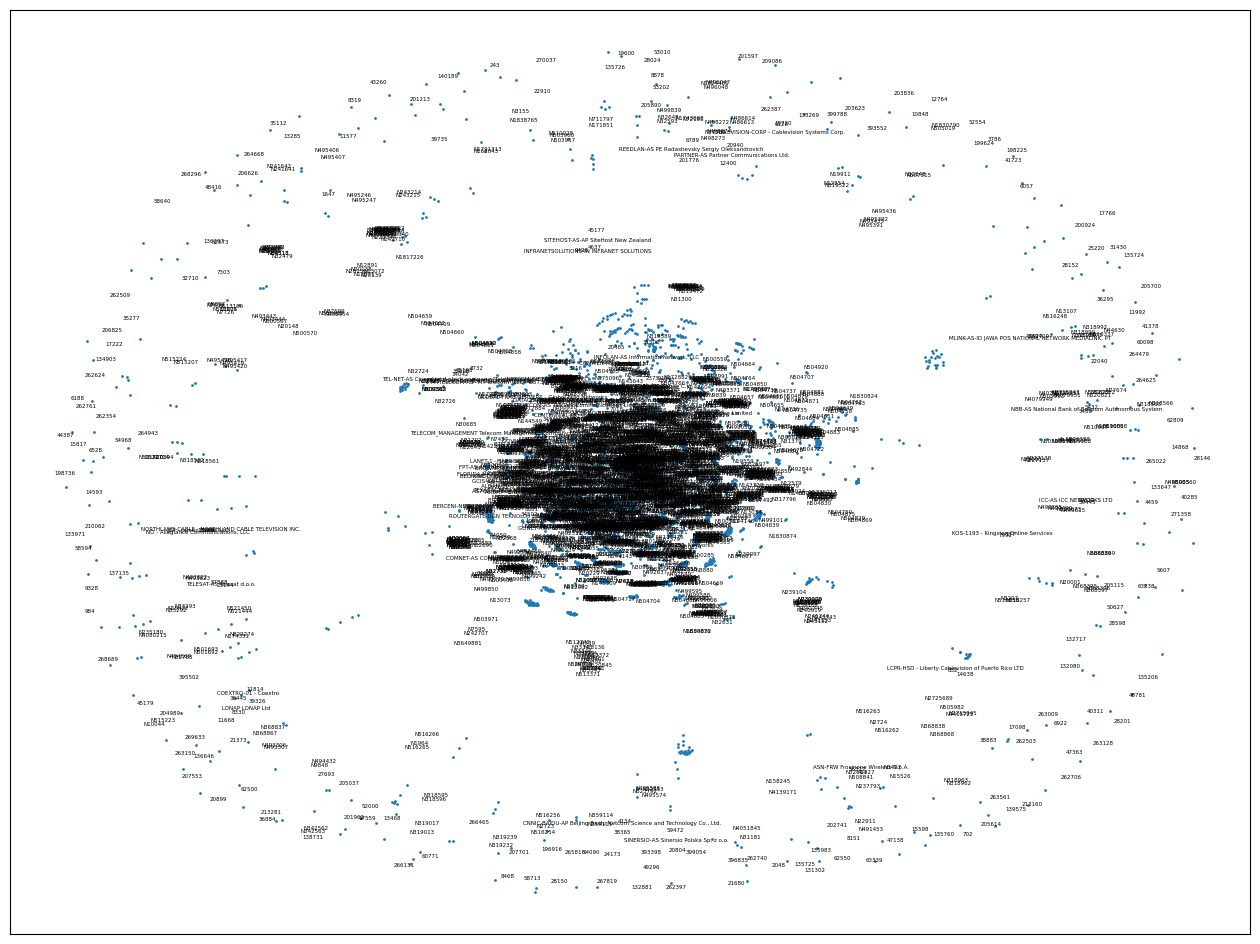

In [122]:
#nx.draw(G, with_labels=False)
plt.figure(43, figsize=(16,12))
nx.draw_networkx_nodes(G, node_size=1, pos=nx.spring_layout(G)) 
_ = nx.draw_networkx_labels(G, font_size=4, pos=nx.spring_layout(G)) 
plt.show()

In [52]:
import matplotlib.pyplot as plt

TO DO : 
- plot maps of individual ASNs and the nodes that are attached to them, geographically
- plot the interconnections of the largest providers, g
- 

# Report

Overview 

- Why does this data exist?
- Overview of the ITDK
    - IPv4 vs IPv6
- Definitions
    - AS
    - Node
    - 

Data Collection

- How is the data collected?
- Where is the data?
- Which columns are inferred vice measured? What is the process by which they are inferred?
- Why do we have geo information for only a subset?

Data Analysis

- What is in the dataset?
- What views help us understand the dataset?
- What inconsistencies or data quality issues exist?
- What can be done with the data?

